Running simulation with history tracking...

Transmission Count by Category:
Category A: 1237 times
Category B: 1347 times
Category C: 0 times

Selecting nodes for spline reconstruction...
Selected nodes: {'Category A': 'node1', 'Category B': 'node6'}
Generating spline reconstruction for node1 (Category A)...
Generating spline reconstruction for node6 (Category B)...

Full view spline reconstruction saved to 'spline_reconstruction_full_view.png'
Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'


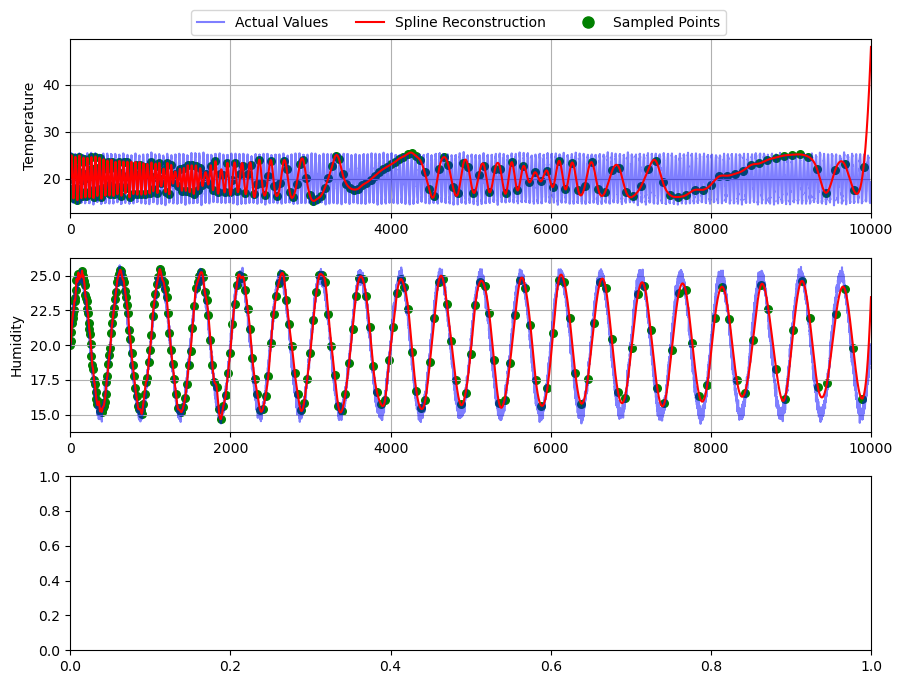

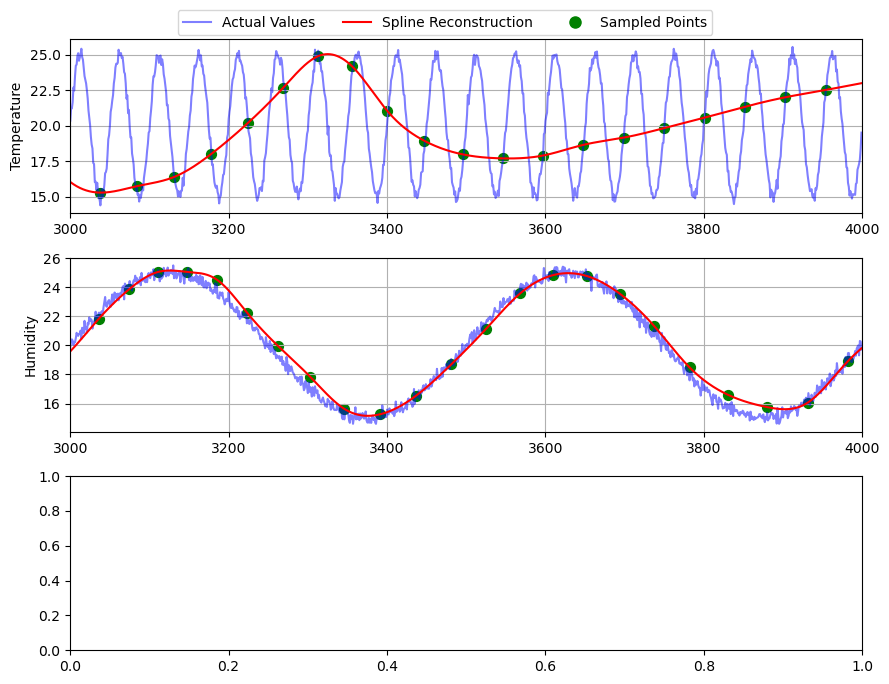

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.3
M = 5 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.7
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.8 # dEWMA parameter for state value
beta_2 = 0.01 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to categorize node based on ID
def categorize_node(node_id):
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 11:
        return 'Category B'
    elif 21 <= node_id <= 30:
        return 'Category C'
    return None

# Main function to simulate Whittle AoII with history tracking for spline reconstruction
def run_simulation_whittle_aoii_with_history(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # New: Store history of all updates for spline reconstruction
    update_history = {col: {'times': [0], 'values': [20.0], 'rates': [0.1]} for col in columns}
    
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            new_state_value, new_rate_of_change = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            state_node[col] = np.array([new_state_value, new_rate_of_change])
            last_update_times[col] = t
            
            # New: Store update in history for spline reconstruction
            update_history[col]['times'].append(t)
            update_history[col]['values'].append(new_state_value)
            #update_history[col]['values'].append(measured_value)
            update_history[col]['rates'].append(new_rate_of_change)

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                category = categorize_node(node_id)
                if category:
                    category_counts[category] += 1

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, update_history

# Function to generate spline reconstruction for a node
def generate_spline_reconstruction(pivot_df, node, update_history):
    """
    Generate spline reconstruction for a node using its update history.
    
    Args:
        pivot_df: Original data DataFrame
        node: Column name of the node to reconstruct
        update_history: Dictionary containing update history for all nodes
        
    Returns:
        Tuple of arrays for (time_points, actual_values, reconstructed_values, update_times, update_values)
    """
    # Get update history for this node
    times = np.array(update_history[node]['times'])
    values = np.array(update_history[node]['values'])
    rates = np.array(update_history[node]['rates'])
    
    # Skip if we don't have enough points for spline
    if len(times) < 4:
        print(f"Not enough update points for {node} to generate spline")
        return None, None, None, None, None
    
    # Get actual values from dataset for comparison
    all_time_points = np.arange(len(pivot_df))
    actual_values = pivot_df[node].values
    
    # Create cubic spline using the values
    cs = CubicSpline(times, values)
    reconstructed_values = cs(all_time_points)
    
    # Create a better spline using both values and rates of change (hermite cubic spline)
    # This is more complex but would give better reconstruction using both x1 and x2
    # For simplicity, we'll use the basic cubic spline for now
    
    return all_time_points, actual_values, reconstructed_values, times, values

# Run the simulation with history tracking
print("Running simulation with history tracking...")
cumulative_rewards, category_counts, update_history = run_simulation_whittle_aoii_with_history(
    pivot_df, columns, M, theta, penalty, aoii_penalty
)

# Print the number of times each category was pulled
print("\nTransmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Select one node from each category for spline reconstruction
# We'll select the first node in each category that has enough update points
print("\nSelecting nodes for spline reconstruction...")

selected_nodes = {}
for col in columns:
    node_id = extract_node_id(col)
    if node_id is None:
        continue
    
    category = categorize_node(node_id)
    if category and category not in selected_nodes and len(update_history[col]['times']) >= 4:
        selected_nodes[category] = col

print(f"Selected nodes: {selected_nodes}")

# First figure: Full view
fig1, axes1 = plt.subplots(3, 1, figsize=(9, 7))

# Create a common legend for full view plots
legend_elements = [
    plt.Line2D([0], [0], color='b', alpha=0.5, label='Actual Values'),
    plt.Line2D([0], [0], color='r', label='Spline Reconstruction'),
    plt.Line2D([0], [0], marker='o', color='g', linestyle='None', markersize=8, label='Sampled Points')
]

# Add a single legend to the top of the first figure
fig1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Define simple labels for y-axis
y_labels = ['Temperature', 'Humidity', 'Light Intensity']

# Loop through categories and generate full view plots
for i, (category, node) in enumerate(selected_nodes.items()):
    print(f"Generating spline reconstruction for {node} ({category})...")
    
    time_points, actual, reconstructed, update_times, update_values = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Full view plots
    ax = axes1[i]
    ax.plot(time_points, actual, 'b-', alpha=0.5)
    ax.plot(time_points, reconstructed, 'r-')
    ax.scatter(update_times, update_values, c='g', marker='o', s=30)
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(0, 10000)  # Set x-axis limit for full view
    
    # Set specific y-limit for Light Intensity plot (top subplot)
    if i == 2:  # First subplot (top)
        ax.set_ylim(300, 500)
        
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_full_view.png", dpi=300)
print("\nFull view spline reconstruction saved to 'spline_reconstruction_full_view.png'")

# Second figure: Zoomed view
fig2, axes2 = plt.subplots(3, 1, figsize=(9, 7))

# Add a single legend to the top of the second figure
fig2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=3, fancybox=True)

# Choose a window size for zoomed view
window_size = 1000
start_time = 3000  # Example starting point

# Loop through categories and generate zoomed view plots
for i, (category, node) in enumerate(selected_nodes.items()):
    time_points, actual, reconstructed, update_times, update_values = generate_spline_reconstruction(
        pivot_df, node, update_history
    )
    
    if time_points is None:
        continue
    
    # Filter data for zoom window
    mask = (time_points >= start_time) & (time_points < start_time + window_size)
    update_mask = (update_times >= start_time) & (update_times < start_time + window_size)
    
    # Zoomed view plots
    ax = axes2[i]
    ax.plot(time_points[mask], actual[mask], 'b-', alpha=0.5)
    ax.plot(time_points[mask], reconstructed[mask], 'r-')
    ax.scatter(update_times[update_mask], update_values[update_mask], c='g', marker='o', s=50)
    ax.set_ylabel(y_labels[i])
    ax.set_xlim(3000, 4000)  # Set x-axis limit for zoomed view
    
    # Set specific y-limit for Light Intensity plot (top subplot)
  
        
    ax.grid(True)
    
    # Only add x-axis label to the bottom subplot
    if i == 2:
        ax.set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig("spline_reconstruction_zoomed_view.png", dpi=300)
print("Zoomed spline reconstruction saved to 'spline_reconstruction_zoomed_view.png'")

plt.show()